# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

In [39]:
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scipy.stats
from IPython.display import HTML
import pandas as pd 

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [4]:
# DO NOT CHANGE
import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [5]:
bandit0 = BanditProblem(0)

In [6]:
bandit0.get_num_arms()

3

In [7]:
bandit0.get_reward(arm=0)

1.8255111545554434

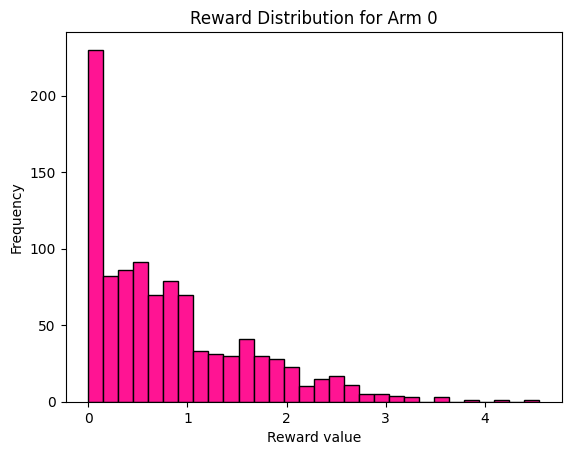

In [21]:
# YOUR CHANGES HERE

rewards_arm0 = []

for _ in range(1000):
    reward = bandit0.get_reward(arm=0)
    rewards_arm0.append(reward)

plt.hist(rewards_arm0, bins=30, color= 'deeppink', edgecolor='black')
plt.xlabel("Reward value")
plt.ylabel("Frequency")
plt.title("Reward Distribution for Arm 0")
plt.show()

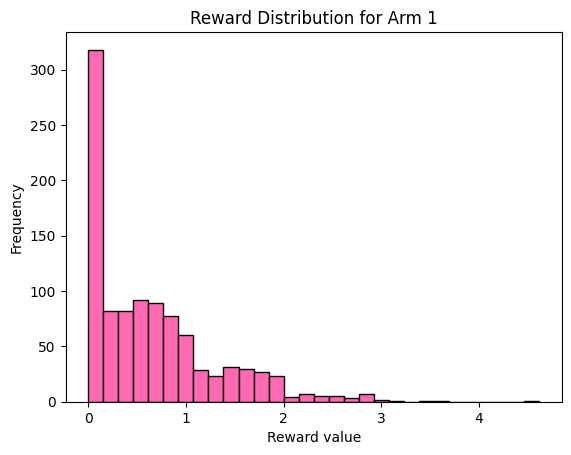

In [22]:
rewards_arm1 = []

for _ in range(1000):
    reward = bandit0.get_reward(arm=1)
    rewards_arm1.append(reward)

plt.hist(rewards_arm1, bins=30, color= 'hotpink', edgecolor='black')
plt.xlabel("Reward value")
plt.ylabel("Frequency")
plt.title("Reward Distribution for Arm 1")
plt.show()

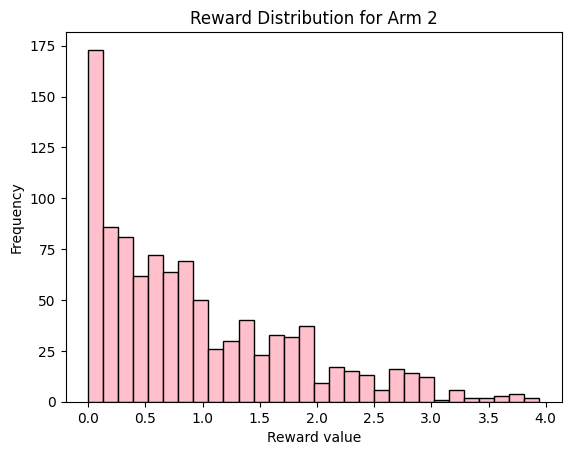

In [25]:
rewards_arm2 = []

for _ in range(1000):
    reward = bandit0.get_reward(arm=2)
    rewards_arm2.append(reward)


plt.hist(rewards_arm2, bins=30, color= 'pink', edgecolor='black')
plt.xlabel("Reward value")
plt.ylabel("Frequency")
plt.title("Reward Distribution for Arm 2")
plt.show()

In [30]:
text = """The rewards are continuous, non-negative, and bounded with high variance, making an uncertainty-aware algorithm appropriate. Upper Confidence Bound (UCB) is suitable because it handles bounded reward distributions without requiring probabilistic priors, while ε-greedy explores randomly and Thompson Sampling relies on reward distribution assumptions that do not hold for this setting."""

with open("algorithm-choice.txt", "w") as f:
    f.write(text)

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week. Write a file "algorithm-choice.txt" that states your choice and give a single sentence justifying your choice and rejecting the alternatives. Keep your explanation concise; you should be able to justify your choice solely based on the type of numbers observed, and whether those match the bandit algorithms that you have learned.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2026.

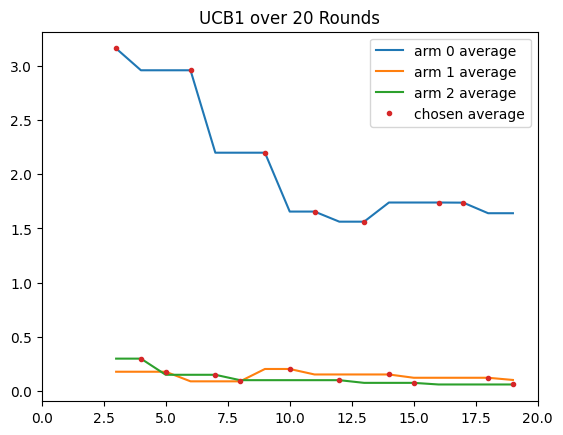

In [34]:
# YOUR CHANGES HERE

# Use the bandit environment from Part 1, but with seed 2026
bandito = BanditProblem(2026)

# number of arms
K = bandito.get_num_arms()   # should be 3
T_max = 1000

arm_counts = [0 for _ in range(K)]
arm_totals = [0.0 for _ in range(K)]
arm_averages = [0.0 for _ in range(K)]
chosen_averages = []

# store action-reward history for history.tsv
actions = []
rewards = []

# UCB1 scaling constant for rewards in [0, c]
# In this environment, rewards are uniform(0,1) * binomial(n, p) with n up to 9
c = 9.0

def sample_reward(j):
    r = bandito.get_reward(arm=j)

    chosen_averages.append(arm_averages[j])

    arm_counts[j] += 1
    arm_totals[j] += r
    arm_averages[j] = arm_totals[j] / arm_counts[j]

    actions.append(j)
    rewards.append(r)

    return r

# sample each arm once
for t in range(K):
    sample_reward(t)

arm_averages_history = []
ucb1_bounds_history = []

# sample using UCB1
for t in range(K, T_max):
    # calculate the UCB1 bound for each arm (scaled by c)
    ucb1_bounds = [
        arm_averages[j] + c * math.sqrt(2 * math.log(t + 1) / arm_counts[j])
        for j in range(K)
    ]

    arm_averages_history.append(arm_averages.copy())
    ucb1_bounds_history.append(ucb1_bounds)

    # pick and sample the arm with the highest bound
    j = int(np.argmax(ucb1_bounds))
    sample_reward(j)

arm_averages_history = np.array(arm_averages_history)
ucb1_bounds_history = np.array(ucb1_bounds_history)
chosen_averages = np.array(chosen_averages)

def plot(T, bounds=True):
    for j in range(K):
        plt.plot(range(K, T), arm_averages_history[:T-K, j], label=f"arm {j} average")
        if bounds:
            plt.plot(range(K, T), ucb1_bounds_history[:T-K, j], label=f"arm {j} bound", linestyle="--")

    if T <= 100:
        plt.plot(range(K, T), chosen_averages[K:T], label="chosen average", linestyle="none", marker=".")

    plt.legend()
    plt.title(f"UCB1 over {T} Rounds")
    plt.xlim(0, T)
    plt.show()

plot(20, bounds=False)


In [ ]:
'''# Initialize the bandit with the required seed
bandito = BanditProblem(2026)

K = bandito.get_num_arms()   # should be 3
T_max = 1000

# UCB1 assumes rewards in [0,1]. Our rewards are bounded in [0, c].
c = 9.0  # max possible reward is approximately 9 in this environment

counts = np.zeros(K, dtype=int)
totals = np.zeros(K, dtype=float)
means = np.zeros(K, dtype=float)

history_actions = []
history_rewards = []

# Pull each arm once to avoid divide-by-zero
for arm in range(K):
    r = bandito.get_reward(arm=arm)
    counts[arm] += 1
    totals[arm] += r
    means[arm] = totals[arm] / counts[arm]

    history_actions.append(arm)
    history_rewards.append(r)

# Main UCB loop
for t in range(K + 1, T_max + 1):  # t starts at K+1
    ucb_scores = means + c * np.sqrt((2.0 * np.log(t)) / counts)

    arm = int(np.argmax(ucb_scores))
    r = bandito.get_reward(arm=arm)

    counts[arm] += 1
    totals[arm] += r
    means[arm] = totals[arm] / counts[arm]

    history_actions.append(arm)
    history_rewards.append(r)'''


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [ ]:
# YOUR CHANGES HERE
history_df = pd.DataFrame({"action": actions, "reward": rewards})
history_df.to_csv("history.tsv", sep="\t", index=False)

history_df

In [43]:
len(history_df)

1000

In [44]:
history_df.head()

,action,reward
0,0,3.162073
1,1,0.177353
2,2,0.298303
3,0,2.759550
4,2,0.000000


In [45]:
history_df.tail()

,action,reward
995,0,2.185100
996,0,0.354824
997,2,0.000000
998,0,0.982299
999,0,4.824929


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [47]:
# YOUR CHANGES HERE
history_df = pd.read_csv("history.tsv", sep="\t")
history_df.head()

,action,reward
0,0,3.162073
1,1,0.177353
2,2,0.298303
3,0,2.759550
4,2,0.000000


In [52]:
min_reward = history_df.groupby(history_df['action']).min()
min_reward

,reward
action,
0,0.0
1,0.0
2,0.0


In [61]:
mean_reward =  history_df.groupby(history_df['action']).mean()
mean_reward

,reward
action,
0,1.245410
1,0.269945
2,0.134349


In [53]:
max_reward = history_df.groupby(history_df['action']).max()
max_reward

,reward
action,
0,6.564312
1,1.857291
2,0.995249


In [67]:
actions_df = pd.DataFrame({
    "min_reward": min_reward["reward"],
    "mean_reward": mean_reward["reward"],
    "max_reward": max_reward["reward"]
})
actions_df = actions_df.reset_index()
actions_df



,action,min_reward,mean_reward,max_reward
0,0,0.0,1.245410,6.564312
1,1,0.0,0.269945,1.857291
2,2,0.0,0.134349,0.995249


In [68]:
actions_df.to_csv("actions.tsv", sep="\t", index=False)

Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Estimate the regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

These estimates should be based on your previous action statistics; you should not use the true action values from the bandit code.

In [71]:
# YOUR CHANGES HERE
# Part 4: Regret Estimates (T = 1000)

T = 1000

# --- (optional but recommended) ensure action columns are ints ---
actions_df["action"] = actions_df["action"].astype(int)
history_df["action"] = history_df["action"].astype(int)

K = actions_df.shape[0]

# 1) Empirical best action (baseline)
best_row = actions_df.loc[actions_df["mean_reward"].idxmax()]
best_action = int(best_row["action"])
best_mean_reward = float(best_row["mean_reward"])

# 2) Uniform strategy
uniform_expected_reward = float(actions_df["mean_reward"].mean())
uniform_regret = T * (best_mean_reward - uniform_expected_reward)
uniform_regret = max(0.0, float(uniform_regret))  # clamp tiny negatives

# 3) Just-i strategy (always pick i)
just_i_regret = (
    actions_df[["action", "mean_reward"]]
    .assign(regret=lambda df: T * (best_mean_reward - df["mean_reward"]))
    .set_index("action")["regret"]
    .to_dict()
)

# clamp tiny negatives + ensure float
just_i_regret = {int(k): max(0.0, float(v)) for k, v in just_i_regret.items()}

# 4) Actual strategy (use observed pick frequencies from history_df)
# Count how many times each action was chosen in the actual run
counts = history_df["action"].value_counts()

# Safer than range(K): align counts to the actual action labels in actions_df
counts = counts.reindex(actions_df["action"], fill_value=0)

# Merge counts with actions_df mean rewards
actual_df = actions_df.merge(
    counts.rename("count"),
    left_on="action",
    right_index=True,
    how="left"
)

actual_df["count"] = actual_df["count"].fillna(0)
actual_df["fraction"] = actual_df["count"] / T

actual_expected_reward = float((actual_df["fraction"] * actual_df["mean_reward"]).sum())
actual_regret = T * (best_mean_reward - actual_expected_reward)
actual_regret = max(0.0, float(actual_regret))  # clamp tiny negatives

# Summary outputs
print("Empirical best action:", best_action)
print("Empirical best mean_reward:", best_mean_reward)
print("Uniform regret:", uniform_regret)
print("Actual regret:", actual_regret)

print("\nJust-i regret:")
for a in sorted(just_i_regret.keys()):
    print(f"Action {a}: {just_i_regret[a]}")

# 5) Write strategies.tsv
rows = []
rows.append({"strategy": "uniform", "regret": uniform_regret})

for a in sorted(just_i_regret.keys()):
    rows.append({"strategy": f"just-{a}", "regret": just_i_regret[a]})

rows.append({"strategy": "actual", "regret": actual_regret})

strategies_df = pd.DataFrame(rows)
strategies_df.to_csv("strategies.tsv", sep="\t", index=False)

strategies_df


Empirical best action: 0
Empirical best mean_reward: 1.245409501530368
Uniform regret: 695.5084089516575
Actual regret: 407.4673941855279

Just-i regret:
Action 0: 0.0
Action 1: 975.4648735162692
Action 2: 1111.0603533387036


,strategy,regret
0,uniform,695.508409
1,just-0,0.000000
2,just-1,975.464874
3,just-2,1111.060353
4,actual,407.467394


In [69]:
# YOUR CHANGES HERE
# Part 4: Regret Estimates (T = 1000)
T = 1000
K = actions_df.shape[0]

# 1) Empirical best action (baseline)
best_row = actions_df.loc[actions_df["mean_reward"].idxmax()]
best_action = best_row["action"]
best_mean_reward = best_row["mean_reward"]

# 2) Uniform strategy
uniform_expected_reward = actions_df["mean_reward"].mean()
uniform_regret = T * (best_mean_reward - uniform_expected_reward)

# 3) Just-i strategy (always pick i)
just_i_regret = (
    actions_df[["action", "mean_reward"]]
    .assign(regret=lambda df: T * (best_mean_reward - df["mean_reward"]))
    .set_index("action")["regret"]
    .to_dict()
)

# 4) Actual strategy (use observed pick frequencies from history_df)
# Count how many times each action was chosen in the actual run
counts = history_df["action"].value_counts().sort_index()

# Ensure all actions 0..K-1 are present (fill missing with 0)
counts = counts.reindex(range(K), fill_value=0)

# Merge counts with actions_df mean rewards
actual_df = actions_df.merge(
    counts.rename("count"),
    left_on="action",
    right_index=True,
    how="left"
)

actual_df["count"] = actual_df["count"].fillna(0)
actual_df["fraction"] = actual_df["count"] / T

actual_expected_reward = (actual_df["fraction"] * actual_df["mean_reward"]).sum()
actual_regret = T * (best_mean_reward - actual_expected_reward)

# Summary outputs
print("Empirical best action:", best_action)
print("Empirical best mean_reward:", best_mean_reward)
print("Uniform regret:", uniform_regret)
print("Actual regret:", actual_regret)

print("\nJust-i regret (first few):")
for a in list(just_i_regret.keys())[:min(5, K)]:
    print(f"Action {a}: {just_i_regret[a]}")

...

Empirical best action: 0.0
Empirical best mean_reward: 1.245409501530368
Uniform regret: 695.5084089516575
Actual regret: 407.4673941855279

Just-i regret (first few):
Action 0: 0.0
Action 1: 975.4648735162692
Action 2: 1111.0603533387036


Ellipsis

Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [70]:
# YOUR CHANGES HERE
regret_summary = pd.DataFrame({
    "strategy": ["uniform", "actual"],
    "regret": [uniform_regret, actual_regret]
})

regret_summary

...

Ellipsis

Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.